In [1]:
from springtime.main import Workflow

In [2]:
recipe = "/home/jovyan/springtime/src/springtime/recipes/model_comparison_usecase.yaml"

In [3]:
Workflow.from_recipe(recipe).execute()

/tmp/data/rnpn/rnpn_npn_data_y_2015_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2016_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2017_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2018_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2019_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping
/tmp/data/rnpn/rnpn_npn_data_y_2020_Deciduous broadleaf_breaking leaf buds_Washington.csv already exists, skipping


Dataset npn_obs loaded with 241 rows
Dataset npn_obs resampled to 241 rows


Dataset daymet loaded with 326310 rows
Dataset daymet resampled to 894 rows
Datesets joined to shape: (894, 25)
Data saved to: /tmp/output/data.csv


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("/tmp/output/data.csv")
df.head()

,year,geometry,breaking leaf buds_doy,tmin_1,tmin_2,tmin_3,tmin_4,tmin_5,tmin_6,tmin_7,...,tmax_3,tmax_4,tmax_5,tmax_6,tmax_7,tmax_8,tmax_9,tmax_10,tmax_11,tmax_12
0,2015,POINT (-122.357971 47.754948),50.0,3.81,5.000,5.59,4.640,10.19,11.625,14.50,...,14.26,14.620,18.91,24.785,25.74,25.52,19.165,17.60,9.450,7.37
1,2015,POINT (-122.377419 47.776241),50.0,3.68,4.955,5.56,4.585,10.11,11.540,14.41,...,14.25,14.635,18.96,24.765,25.73,25.58,19.165,17.60,9.475,7.41
2,2015,POINT (-122.185921 47.255966),56.0,3.27,4.915,5.66,4.920,9.83,11.760,14.66,...,14.04,14.070,18.19,25.545,26.81,26.20,18.965,16.63,9.120,6.62
3,2015,POINT (-121.861725 47.952686),50.0,1.93,3.440,4.21,2.920,9.24,10.015,12.76,...,13.13,13.765,17.79,24.680,25.72,25.52,18.025,15.80,7.835,5.09
4,2015,POINT (-122.686279 45.513168),99.0,3.70,5.290,6.23,4.825,9.91,12.530,14.75,...,17.13,15.765,21.45,28.005,29.36,28.66,22.720,19.08,10.715,8.00


In [6]:
df.shape

(894, 27)

In [7]:
df.dropna(inplace = True)
df.shape

(241, 27)

In [8]:
df.drop(columns = ["year","geometry"], inplace = True)

In [9]:
df.shape

(241, 25)

In [10]:
# import RegressionExperiment and init the class
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

In [11]:
# init setup on exp
exp.setup(df, target = 'breaking leaf buds_doy', session_id = 123)

,Description,Value
0,Session id,123
1,Target,breaking leaf buds_doy
2,Target type,Regression
3,Original data shape,"(241, 25)"
4,Transformed data shape,"(241, 25)"
5,Transformed train set shape,"(168, 25)"
6,Transformed test set shape,"(73, 25)"
7,Numeric features,24
8,Preprocess,True
9,Imputation type,simple


In [12]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

In [13]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# inherit the subclasses
class ExponentialRegressor(BaseEstimator, RegressorMixin):

  # make the init method
  def __init__(self,maxfev = 3000): 
    self.maxfev = maxfev
    return (None)
  
  # make the custom function
  def exp_curve(self,X,*args):
    y_ = np.array(X).dot(np.array(args[1:]))
    y_ = np.exp(y_)
    y = y_*args[0]
    return (y)
  
  # make fit method.
  def fit(self,X,y):
    # check the X & y
    X, y = check_X_y(X, y)
    p0 = np.zeros(X.shape[1]+1)
    self.coefficients_, *_ = curve_fit(self.exp_curve,X,y,p0 = p0)
    # Note that self.coefficients_ has a subsequent "-",
    # enough to fullfil the requirement.
    return (None)
  
  # make the predict method.
  def predict(self, X):
    self.predictions = self.exp_curve(X,*self.coefficients_)
    return (self.predictions) 

In [14]:
er = ExponentialRegressor()

In [15]:
#  RegressionTree, LinearRegression, LogisticRegression not implemented inline with the pycaret
from interpret.glassbox import ExplainableBoostingRegressor
model = ExplainableBoostingRegressor()
exp.create_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33.4232,2443.4244,49.4310,0.5143,0.6364,0.5511
1,45.4228,5940.9017,77.0772,0.4499,0.7165,0.4608
2,23.5023,1240.1786,35.2162,0.8606,0.3306,0.2950
3,34.4129,2149.9453,46.3675,0.4625,0.6190,0.7070
4,27.7259,1323.0719,36.3741,0.7576,0.5151,0.4690
5,23.5232,1046.4490,32.3489,0.8327,0.4810,0.5022
6,21.7696,642.4940,25.3475,0.8318,0.3076,0.2769
7,47.4773,4386.5614,66.2311,0.4914,0.7356,0.8810
8,29.2698,1650.6301,40.6279,0.7769,0.4712,0.4820


ExplainableBoostingRegressor()

In [16]:
from interpret.glassbox import ExplainableBoostingRegressor
ebm = ExplainableBoostingRegressor()

In [17]:
# compare baseline models
best = exp.compare_models(include = ["rf","ada","dt","lr","gbr",svr_rbf,er,ebm])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,AdaBoost Regressor,26.6921,1470.7824,36.1062,0.7910,0.4942,0.4973,0.2710
0,Random Forest Regressor,24.5937,1467.8504,35.9053,0.7857,0.4724,0.4236,0.2740
5,Support Vector Regression,26.9678,1684.4732,39.4120,0.7467,0.5089,0.4589,0.0240
2,Decision Tree Regressor,26.0720,1761.6493,39.8640,0.7286,0.5242,0.4199,0.2000
4,Gradient Boosting Regressor,27.4739,1786.8737,40.3415,0.7225,0.5139,0.4668,0.0320
7,ExplainableBoostingRegressor,31.5548,2216.2115,44.5606,0.6863,0.5263,0.5084,0.0310
3,Linear Regression,40.8649,3029.9195,53.8883,0.5328,0.6835,0.6440,0.0220
6,ExponentialRegressor,37.4157,3127.3444,50.8761,0.4162,0.6428,0.5885,0.0270


In [18]:
best

AdaBoostRegressor(random_state=123)

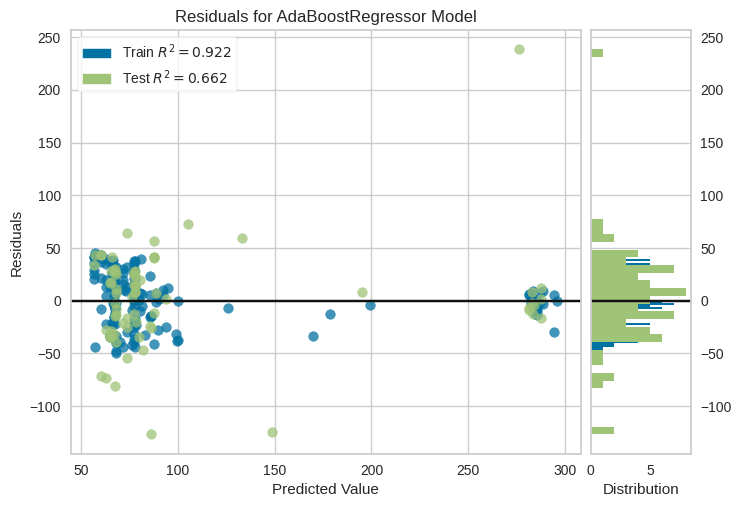

In [19]:
# plot residuals
exp.plot_model(best, plot = 'residuals')


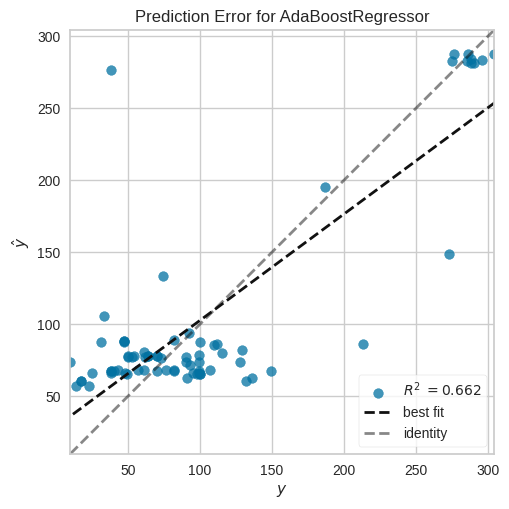

In [20]:
# plot error
exp.plot_model(best, plot = 'error')